In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample,lfilter,lfilter_zi
from scipy import signal

from os import path

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=30256, comptype='NONE', compname='not compressed')


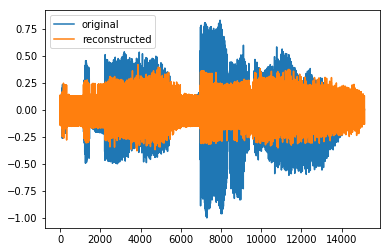

In [4]:
##Takes a file and converts it to pulse encoding

filename  = '../example_sounds/mario_16bit.wav'
basename  = path.basename(filename)
directory = path.dirname(filename)
base,ext = path.splitext(basename)
f = wave.open(filename)
frames = f.getnframes()
byteframes = f.readframes(frames)
print(f.getparams())
if f.getparams().sampwidth == 2:
    dtype=np.int16
else:
    dtype = np.int8
fr = np.frombuffer(byteframes,dtype=dtype)


upsample = 1
fr = resample(fr,int(frames / 2)) 
fr = fr - np.mean(fr)
fr = fr / np.max([np.max(fr),np.abs(np.min(fr))] )


ntotal = len(fr)
x = fr
y = np.zeros(ntotal)

# qe = 0 #running quantization error
# for n in range(1,ntotal):
#     if x[n] >= qe:
#         y[n] = 1
#     else:
#         y[n] = -1
#     qe = y[n] - x[n] + qe

## 2-tap decimating filter?
y = np.zeros(ntotal)
acc1 = np.zeros(ntotal)
acc2 = np.zeros(ntotal)
qe1 = 0
qe2 = 0
qe3 = 0
for n in range(0,ntotal):
    qe1 += x[n] - y[n-1]
    qe2 += qe1 - y[n-1]
    
    if qe2 >= 0:
        y[n] = 1
    else:
        y[n] = -1

plt.plot(x,label="original")
# plt.stem(y,label="pulsecode")


#pulsecode output
y_packed = np.zeros(len(y))
y_packed[np.where(y == 1)] = 1 #Decimate in this step also
y_packed = y_packed.astype(np.int8)
y_ = y_packed
y_packed = np.packbits(y_packed)
y_packed.tofile(path.join(directory, base + '.pdm'))


reconstructed = np.zeros(len(y)+1)
for n in range(1,len(y)):
    reconstructed[n] = (1-1/3)*reconstructed[n-1] + y[n]*1/3
    
b = [1/8]
a = [1.0, -(1-1/8)]

# b = signal.firwin(3, 0.1, window=('gaussian', 10.2))
# a = 1

reconstructed = signal.lfilter(b,a,y)
# reconstructed = signal.convolve(y, b, mode='same')
plt.plot(reconstructed,label="reconstructed")
plt.legend()

#wave output
sig = reconstructed*2**15 #reconstitute for wav between 0 and maxint, 16bit
f_out = wave.open(path.join(directory,base + '_reconstructed.wav'),mode='wb')
upsample = 1

(nchannels,sampwidth,framerate,nframe,compytype,compname) = f.getparams()
f_out.setparams((nchannels,sampwidth,framerate/2,int(nframe/2),compytype,compname) )

sig = sig.astype(np.int16)
f_out.writeframesraw(memoryview(sig))

In [346]:
b

array([0.18608463, 0.20682163, 0.21418747, 0.20682163, 0.18608463])

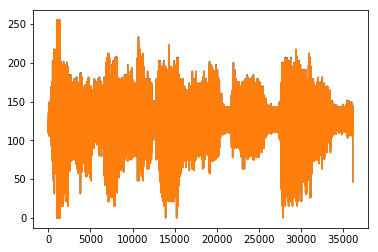

In [353]:
import pandas as pd
wav = pd.read_csv('./bmo_tiny/wave.csv',names=['w','t'],header=None)
plt.plot((wav.w+1)/2*255)
plt.plot(wav.t)
# plt.plot(reconstructed[:200])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


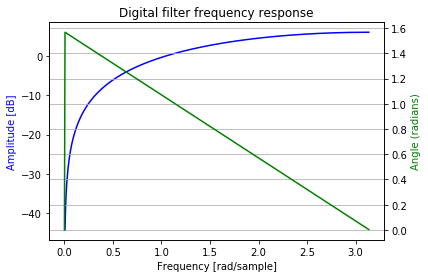

In [365]:
from scipy import signal
b = signal.firwin(5, 0.15, window=('gaussian', 5.2))
b = [1/8]
a = [1, -(1-1/8)]

b = [1, -1]
a = [1]
w, h = signal.freqz(b,a)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

In [215]:
b

array([2.59770958e-04, 1.09099670e-02, 6.19317513e-02, 1.65599130e-01,
       2.61299381e-01, 2.61299381e-01, 1.65599130e-01, 6.19317513e-02,
       1.09099670e-02, 2.59770958e-04])